Today there was an announcement that the UK government would be having a snap election. This triggered a lot of heat on Twitter. As someone who lives in the UK, I was interested to see whether I could get some insight into this data, to have an idea at what kind of response the public gave.

## Setting up a listener

Firstly we need to get the data from Twitter. I managed to get something set up in Python in a short time using the Twitter Streaming API, saving the code to `twitter_streaming.py`. The code for this is below.

```python 
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import sys

from ConfigParser import ConfigParser

config = ConfigParser()
config.readfp(open('config.ini', 'r'))

#Variables that contains the user credentials to access Twitter API 
access_token = config.get('setup', 'access_token')
access_token_secret = config.get('setup', 'access_token_secret')
consumer_key = config.get('setup', 'consumer_key')
consumer_secret = config.get('setup', 'consumer_secret')


#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):

    def on_data(self, data):
        print data
        return True

    def on_error(self, status):
        print status


if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)
    
    keywords = sys.argv[1:]
    print keywords

    #This line filter Twitter Streams to capture data by the keywords
    stream.filter(track=keywords)
```

The code above is from a really useful blog post [An Introduction to Text Mining using Twitter Streaming API and Python](http://adilmoujahid.com/posts/2014/07/twitter-analytics/). This helped me get started really quickly so I was able to start pulling data shortly after the event happened. I captured around 1.5 hours of data by running this:

```
python twitter_streaming.py #TheresaMay #generalelection #brexit > brexit.txt
```

## Implementing Naive Bayes

Next thing, I set up a very simple implementation of Naive Bayes sentiment classification, in an attempt to classify the tweets as negative or positive. I used the blog post [Training and Testing the Naive Bayes Classifier](http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/) to help me with this.

I created code in the file `sentiment.py` as the below.

```python
import json

# NLTK library for sentiment analysis
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

# source data file and output data file
tweets_data_path = 'brexit.txt'
output_file_path = 'brexit_sentiment.txt'

# function to clean a tweet and return words
def extract_words(text):
    
    text = text.lower()
    text = re.sub(r'[^\w#\s]', ' ', text)
    
    return text.split()
    
# function to extract the word features from a list of words
def word_feats(words):
    return dict([(word, True) for word in words])
    
# training the classifier with the positive and negative
# items in the movie reviews corpus
negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
 
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]
 
trainfeats = negfeats + posfeats

classifier = NaiveBayesClassifier.train(trainfeats)

# one by one get the sentiment of each tweet and save into the output file
with open(tweets_data_path, "r") as tweets_file:
    with open(output_file_path, 'w') as output_file:
        for line in tweets_file:
            try:
                
                tweet = json.loads(line)
                tweet_text = tweet['text']
    
                words = extract_words(tweet['text'])
                
                sentiment = classifier.classify(word_feats(words))
                data = { 
                    'tweet': tweet,
                    'sentiment': sentiment
                    }
            
                json.dump(data, output_file)
                output_file.write('\n')
                
            except:
                continue

```

Now we have a JSON file with 'sentiment' containing either 'neg' or 'pos', and 'tweet' containing all the data of the tweet.

## Analysis

Lastly, I did some very simple analyis of the data that was saved. I created a new file for this in `sentiment_analysis.py`, based on the previously mentioned blog post [An Introduction to Text Mining using Twitter Streaming API and Python](http://adilmoujahid.com/posts/2014/07/twitter-analytics/).

I took a 5% sample of the data and ran some counts of this, plotting them.

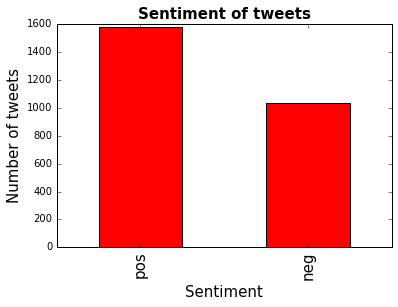

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import random
from pandas.io.json import json_normalize

tweets_data_path = 'brexit_sentiment.txt'

tweets_data = []

i = 0
with open(tweets_data_path, "r") as tweets_file:
    for line in tweets_file:
        i += 1
        try:
            if i % 20 == 0:
                tweet = json.loads(line)
                tweets_data.append(tweet)
        except:
            continue
        
tweets = json_normalize(tweets_data)

tweets_by_sentiment = tweets['sentiment'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Sentiment', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Sentiment of tweets', fontsize=15, fontweight='bold')
tweets_by_sentiment.plot(ax=ax, kind='bar', color='red')